## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_dataloader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_dataloader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
train_dataloader

In [ ]:
for img, label in train_dataloader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

In [ ]:

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
    
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                out = model(X_batch)
                loss = loss_fn(out, y_batch)


             
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    return train_loss, val_loss, val_accuracy
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    
# Your experiments, training and validation loops here

In [ ]:
n_epochs = 15
import time
train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_function, opt, n_epochs)

Epoch 1 of 15 took 11.052s
	  training loss: 0.599390
	validation loss: 0.460831
	validation accuracy: 0.834
Epoch 2 of 15 took 10.992s
	  training loss: 0.404937
	validation loss: 0.405895
	validation accuracy: 0.856
Epoch 3 of 15 took 11.054s
	  training loss: 0.363295
	validation loss: 0.393287
	validation accuracy: 0.860
Epoch 4 of 15 took 11.021s
	  training loss: 0.337289
	validation loss: 0.361381
	validation accuracy: 0.872
Epoch 5 of 15 took 11.057s
	  training loss: 0.315389
	validation loss: 0.365703
	validation accuracy: 0.867
Epoch 6 of 15 took 10.976s
	  training loss: 0.296396
	validation loss: 0.367117
	validation accuracy: 0.868
Epoch 7 of 15 took 11.103s
	  training loss: 0.287777
	validation loss: 0.338325
	validation accuracy: 0.877
Epoch 8 of 15 took 10.928s
	  training loss: 0.273990
	validation loss: 0.335023
	validation accuracy: 0.879
Epoch 9 of 15 took 11.153s
	  training loss: 0.264269
	validation loss: 0.323987
	validation accuracy: 0.885
Epoch 10 of 15 took

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

0.88876953125


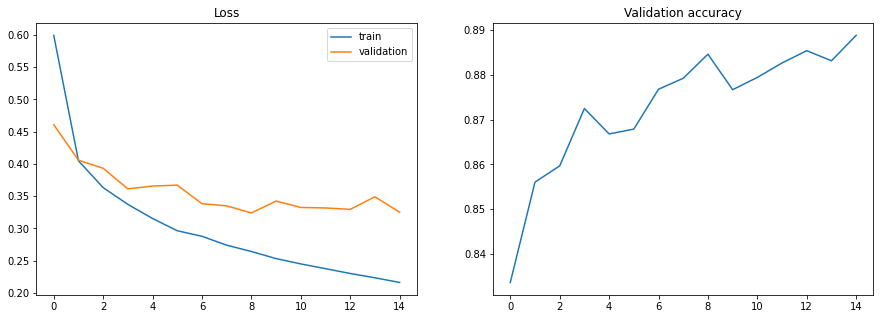

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)
print(np.max(val_accuracy))

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.LeakyReLU(),
            nn.Linear(500,300),
            nn.LeakyReLU(),
            nn.Linear(300, 100),
            nn.LeakyReLU(),
            nn.Linear(100,10),
            nn.LeakyReLU(),
            nn.Linear(10,num_classes),       
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
         LeakyReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 300]         150,300
         LeakyReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
         LeakyReLU-9                   [-1, 10]               0
           Linear-10                   [-1, 10]             110
Total params: 574,020
Trainable params: 574,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.19
Estimated T

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
n_epochs = 25
train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

# Your experiments, come here

Epoch 1 of 25 took 11.572s
	  training loss: 0.653083
	validation loss: 0.431565
	validation accuracy: 0.848
Epoch 2 of 25 took 11.486s
	  training loss: 0.394980
	validation loss: 0.407594
	validation accuracy: 0.850
Epoch 3 of 25 took 11.360s
	  training loss: 0.347109
	validation loss: 0.369870
	validation accuracy: 0.869
Epoch 4 of 25 took 11.432s
	  training loss: 0.320182
	validation loss: 0.346089
	validation accuracy: 0.878
Epoch 5 of 25 took 11.655s
	  training loss: 0.299595
	validation loss: 0.337255
	validation accuracy: 0.879
Epoch 6 of 25 took 11.484s
	  training loss: 0.283359
	validation loss: 0.343595
	validation accuracy: 0.874
Epoch 7 of 25 took 11.586s
	  training loss: 0.268247
	validation loss: 0.332208
	validation accuracy: 0.880
Epoch 8 of 25 took 11.796s
	  training loss: 0.257857
	validation loss: 0.320889
	validation accuracy: 0.883
Epoch 9 of 25 took 11.619s
	  training loss: 0.242936
	validation loss: 0.315887
	validation accuracy: 0.889
Epoch 10 of 25 took

0.89912109375


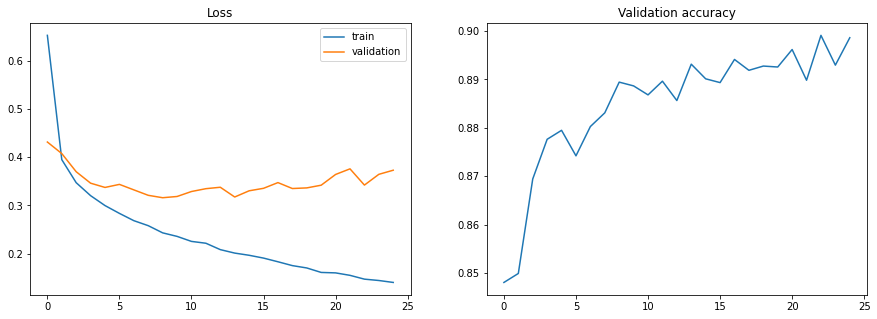

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)
print(np.max(val_accuracy))

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(600,500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400,300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(300,200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(), 
            nn.Linear(200,100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100,10),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
       BatchNorm1d-3                  [-1, 600]           1,200
         LeakyReLU-4                  [-1, 600]               0
           Dropout-5                  [-1, 600]               0
            Linear-6                  [-1, 500]         300,500
       BatchNorm1d-7                  [-1, 500]           1,000
         LeakyReLU-8                  [-1, 500]               0
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 400]         200,400
      BatchNorm1d-11                  [-1, 400]             800
        LeakyReLU-12                  [-1, 400]               0
          Dropout-13                  [-1, 400]               0
           Linear-14                  [

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
n_epochs = 20
train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

# Your experiments, come here

Epoch 1 of 20 took 14.472s
	  training loss: 0.955577
	validation loss: 0.521549
	validation accuracy: 0.811
Epoch 2 of 20 took 14.541s
	  training loss: 0.583717
	validation loss: 0.441844
	validation accuracy: 0.843
Epoch 3 of 20 took 14.316s
	  training loss: 0.518930
	validation loss: 0.416830
	validation accuracy: 0.850
Epoch 4 of 20 took 14.326s
	  training loss: 0.479147
	validation loss: 0.391218
	validation accuracy: 0.861
Epoch 5 of 20 took 14.372s
	  training loss: 0.453108
	validation loss: 0.397935
	validation accuracy: 0.861
Epoch 6 of 20 took 14.583s
	  training loss: 0.439116
	validation loss: 0.371849
	validation accuracy: 0.866
Epoch 7 of 20 took 14.358s
	  training loss: 0.420487
	validation loss: 0.364288
	validation accuracy: 0.871
Epoch 8 of 20 took 14.398s
	  training loss: 0.406821
	validation loss: 0.354062
	validation accuracy: 0.874
Epoch 9 of 20 took 14.549s
	  training loss: 0.395782
	validation loss: 0.350392
	validation accuracy: 0.874
Epoch 10 of 20 took

0.887890625


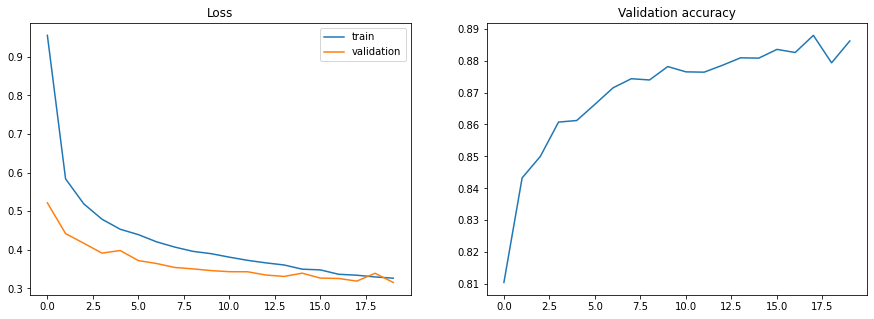

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)
print(np.max(val_accuracy))

### Conclusions:
_Write down small report with your conclusions and your ideas._